<a href="https://colab.research.google.com/github/Software566/Akasha__qianjunz_aidanw26_ivang86_jasonc573/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving car.jpg to car (1).jpg


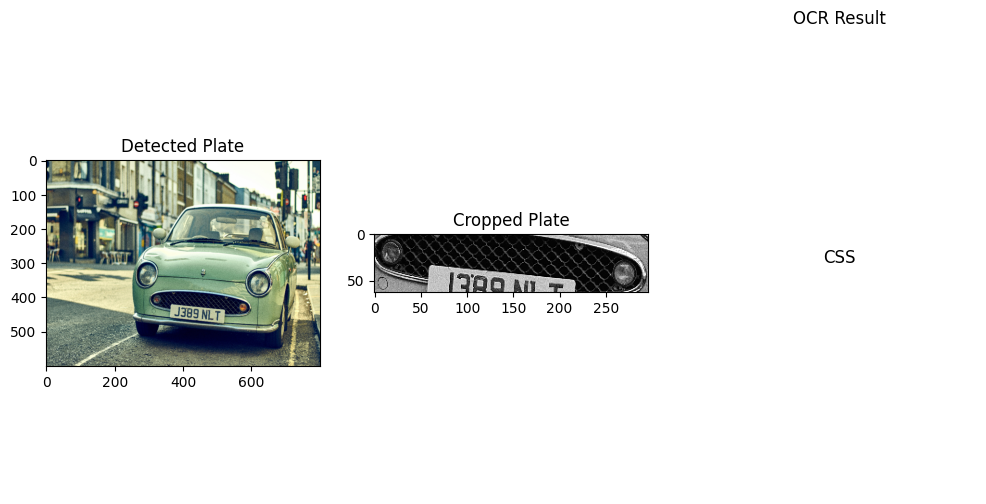

In [2]:


import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow

# Upload image
uploaded = files.upload()
image_path = next(iter(uploaded))
img = cv2.imread("car.jpg")

# Preprocessing
def preprocess(img):
    img_resized = cv2.resize(img, (800, 600))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    blur = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(blur, 30, 200)
    return img_resized, gray, edged

img_resized, gray, edged = preprocess(img)

# License plate detection
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

plate_contour = None
for contour in contours:
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
    if len(approx) in range(4, 7):
        plate_contour = approx
        break

if plate_contour is not None:
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [plate_contour], 0, 255, -1)
    plate = cv2.bitwise_and(img_resized, img_resized, mask=mask)

    (x, y) = np.where(mask == 255)
    topx, topy = np.min(x), np.min(y)
    bottomx, bottomy = np.max(x), np.max(y)
    cropped = gray[topx:bottomx+1, topy:bottomy+1]

    # FIXED SHARPENING STEP
    if cropped.size > 0:  # Ensure we have a valid ROI
        blurred = cv2.GaussianBlur(cropped, (3, 3), 0)
        cropped = cv2.addWeighted(cropped, 1.5, blurred, -0.5, 0)

    # OCR with improved configuration
    plate_text = pytesseract.image_to_string(cropped,
                                          config='--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(131), plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)), plt.title('Detected Plate')
    plt.subplot(132), plt.imshow(cropped, cmap='gray'), plt.title('Cropped Plate')
    plt.subplot(133), plt.text(0.5, 0.5, plate_text.strip(), fontsize=12, ha='center'), plt.axis('off'), plt.title('OCR Result')
    plt.show()
else:
    print("No license plate found!")